# Code to work with SK elevations

In [4]:
import pandas as pd
import numpy as np
import datetime
import os
import fiona
import rasterio as rio
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
from rasterstats import zonal_stats
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from scipy import stats
import cmocean
import glob

# 1) Choose centerline file

In [190]:
# load the centerline file ########################
clinepath = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/centerlines/'
for file in os.listdir(clinepath):
    if file.endswith('.shp'):
        print(file)
cfile = 'centerline_n_utm07_250m_circlebuffer.shp'
########################################################
print(); print(cfile, 'CHOSEN')

if cfile.split('_')[1] == 'n':
    northline = True
    newfolder = 'centerline-north'
elif cfile.split('_')[1] == 's':
    northline = False
    newfolder = 'centerline-south'
else:
    print('Check filename:')
    print(cfile.split('_'))
print(newfolder)
spacing = cfile.split('_')[3]
print(spacing)

# read with geopandas
cline_gdf = gpd.read_file(clinepath+cfile)
geoms = cline_gdf.geometry.values
cline_gdf

centerline_s_utm07_250m_squarebuffer.shp
centerline_n_utm07_250m_circlebuffer.shp
centerline_n_utm07_250m.shp
centerline_n_utm07_250m_squarebuffer.shp
centerline_s_utm07_250m_circlebuffer.shp
centerline_s_utm07_500m_circlebuffer.shp
centerline_n_utm07_500m_circlebuffer.shp
centerline_n_utm07_121pts.shp
centerline_n_utm07_500m.shp
centerline_n_final_wgs84.shp
centerline_s_final_wgs84.shp
centerline_n_final_utm07.shp
centerline_s_final_utm07.shp
centerline_s_utm07_250m.shp

centerline_n_utm07_250m_circlebuffer.shp CHOSEN
centerline-north
250m


,id,distance,angle,geometry
0,None,100.0,120.762720,"POLYGON ((560860.191 6672605.735, 560854.073 6..."
1,None,350.0,120.762720,"POLYGON ((561075.015 6672477.864, 561068.897 6..."
2,None,600.0,120.762720,"POLYGON ((561289.838 6672349.993, 561283.720 6..."
3,None,850.0,111.317912,"POLYGON ((561512.949 6672239.084, 561506.831 6..."
4,None,1100.0,111.317912,"POLYGON ((561745.843 6672148.199, 561739.725 6..."
...,...,...,...,...
116,None,29100.0,119.116146,"POLYGON ((578501.133 6654291.947, 578495.015 6..."
117,None,29350.0,119.116146,"POLYGON ((578719.542 6654170.301, 578713.424 6..."
118,None,29600.0,118.610460,"POLYGON ((578938.435 6654049.534, 578932.317 6..."
119,None,29850.0,118.610460,"POLYGON ((579157.909 6653929.821, 579151.791 6..."


# 2) Extract elevations at 250m / 500m spacing (choose corresponding centerline file)

In [5]:
# dem_path = '/Users/jukesliu/Documents/TURNER/DATA/STRESS_BALANCE/stress_maps/'
# dem_outpath = '/Users/jukesliu/Documents/TURNER/DATA/STRESS_BALANCE/stress_maps/centerline_basal/from2014/'
dem_path = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/final-DEMs/'
dem_outpath = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/'
prof_count = 0

In [221]:
# pull DEM elevations
for file in os.listdir(dem_path):
    if file.endswith('err.tif'):
#         ds = file.split('_')[0]
#     if file.endswith('.tif') and 'dtau_b' in file and '20140318' in file:
#         ds = file.split('_')[4]
#         print(ds)
        
        # open DEM
        src = rio.open(dem_path+file); elev = src.read(1); affine=src.transform
        
        # extract mean elevations
        dists = []; mean_elev = []
        for idx2, row2 in cline_gdf.iterrows():
            geom = row2.geometry
            dist = row2.distance
            dists.append(dist)
            try:
                out_image, out_transform = mask(src, [mapping(geom)], crop=True)
                crop_array = out_image[0,:,:]
                crop_array[crop_array < -1e3] = np.NaN
#                 mean_elev.append(np.nanmean(crop_array))
                mean_elev.append(np.nanmax(crop_array))
            except Exception:
                mean_elev.append(np.NaN)
                pass
        mean_elev = np.array(mean_elev); dists = np.array(dists)
        if northline: # flip distances for northern centerline
            dists = np.flip(dists)
        mean_elev[mean_elev == 0] = np.NaN # differences should never be exactly 0
        
        # write centerline data to csv
#         new_df = pd.DataFrame(list(zip(dists, mean_elev)), columns=['dist_m','mean_elev'])
        new_df = pd.DataFrame(list(zip(dists, mean_elev)), columns=['dist_m','h'])
#         new_df.to_csv(dem_outpath+'centerline_'+cfile.split('_')[1]+'_'+spacing+'_'+ds+'.csv')
        new_df.to_csv(dem_outpath+'centerline_n_'+spacing+'_herr.csv')
        new_df
        
        prof_count+=1

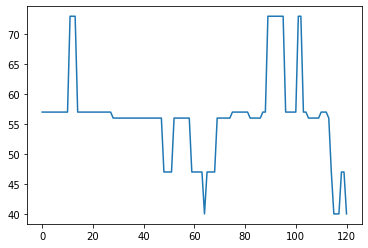

In [222]:
plt.plot(new_df.h)

# Calculate per-pixel st. dev in the 2020-06-05 OIB LIDAR data

In [28]:
# laspath = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/Surface/Lidar/ILAKS1B_2020_157_Turner.csv'
# lidar_df = pd.read_csv(laspath, index_col=0)
# lidar_df.columns

In [27]:
# plt.imshow(elev, vmin=0);
# plt.colorbar()
# plt.show()

## Merge centerline elevations from acquisitions close in time

Currently combining the 3 ASTER DEMs from 20161019 (2) and 20161020 (1) as well as the 2 WorldView DEMs from 20180117 and 20180128.

In [6]:
df2016 = pd.read_csv(glob.glob(dem_outpath+'centerline_'+cfile.split('_')[1]+'_'+spacing+'*2016*.csv')[0])
df2016

NameError: name 'cfile' is not defined

In [154]:
files201801

['/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/centerline_n_250m_20180117.csv',
 '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/centerline_n_250m_20180122.csv',
 '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/centerline_n_250m_20180128.csv']

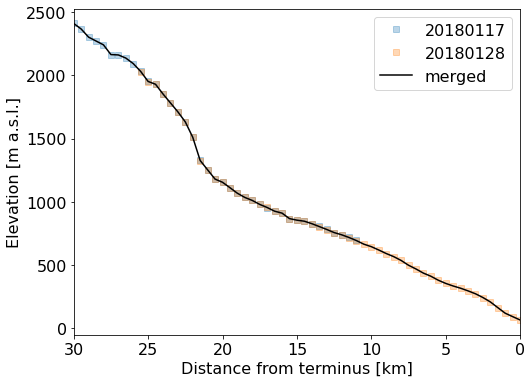

In [169]:
dem_outpath = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/'

### 2018 #####################################################################################
files201801 = glob.glob(dem_outpath+'centerline_'+cfile.split('_')[1]+'_'+spacing+'*201801*.csv') # change glob search pattern!
files201801.sort()
files201801 = [files201801[0], files201801[2]]

# plot the individual elevations
legend_entries = []
fig, ax = plt.subplots(1,figsize=(8,6))
elevation_lists = []
for file in files201801:
    df = pd.read_csv(file)
    ds = file.split('/')[-1].split('_')[-1][:-4] # grab date
    ax.plot(df.dist_m/1000, df.mean_elev, 's', alpha=0.3)
    elevation_lists.append(np.array(df.mean_elev))
    legend_entries.append(ds)
mean_elevations = np.nanmean(elevation_lists, axis=0)
legend_entries.append('merged')

# plot merged result and original result
ax.plot(df.dist_m/1000, mean_elevations, 'k')
ax.set_xlim(30,0)
ax.set_xlabel('Distance from terminus [km]', fontsize=fs)
ax.set_ylabel('Elevation [m a.s.l.]', fontsize=fs)
plt.tick_params(labelsize=fs)
plt.legend(legend_entries, fontsize=fs)
plt.show()

# export result to csv
merged_dem_df = pd.DataFrame(list(zip(df.dist_m, mean_elevations)), columns=['dist_m','mean_elev'])
# merged_dem_df.to_csv(dem_outpath+file.split('/')[-1][:-12]+'20180122.csv')

# # ### 2016 #####################################################################################
# files201610 = glob.glob(dem_outpath+'centerline_'+cfile.split('_')[1]+'_'+spacing+'*201610*.csv') # change glob search pattern!
# files201610.sort()
# files201610 = files201610[:-1]
# df2016wv = pd.read_csv(glob.glob(dem_outpath+'centerline_'+cfile.split('_')[1]+'_'+spacing+'*201607*.csv')[0])

# # plot the individual elevations
# legend_entries = []
# fig, ax = plt.subplots(1,figsize=(8,6))
# # elevation_lists = []
# # for file in files201610:
# #     df = pd.read_csv(file)
# #     ds = file.split('/')[-1].split('_')[-1][:-4] # grab date
# #     ax.plot(df.dist_m/1000, df.mean_elev, 's', alpha=0.3)
# #     elevation_lists.append(np.array(df.mean_elev))
# #     legend_entries.append(ds)
# # mean_elevations = np.nanmean(elevation_lists, axis=0)
# legend_entries.append('20161019 (merged)')

# # plot merged result and original result
# ax.plot(df.dist_m/1000, mean_elevations, 'k')
# ax.plot(df2016wv.dist_m/1000, df2016wv.mean_elev, 'r-'); legend_entries.append('20160717 (WV)')
# ax.set_xlim(30,0)
# ax.set_xlabel('Distance from terminus [km]', fontsize=fs)
# ax.set_ylabel('Elevation [m a.s.l.]', fontsize=fs)
# plt.tick_params(labelsize=fs)
# plt.legend(legend_entries, fontsize=fs)
# plt.show()

# # export result to csv
# merged_dem_df = pd.DataFrame(list(zip(df.dist_m, mean_elevations)), columns=['dist_m','mean_elev'])
# merged_dem_df.to_csv(dem_outpath+file.split('/')[-1][:-12]+'20161019.csv')

In [164]:
df2016.head()

,Unnamed: 0,dist_m,mean_elev
0,0,30100.0,NaN
1,1,29850.0,NaN
2,2,29600.0,2351.1406
3,3,29350.0,2326.4883
4,4,29100.0,2290.5947


In [170]:
diff_df = pd.DataFrame(list(zip(df2016.dist_m, merged_dem_df.mean_elev - df2016.mean_elev)), columns=['dist_m','mean_elev_diff'])
diff_df

,dist_m,mean_elev_diff
0,30000.0,NaN
1,29500.0,10.400649
2,29000.0,2.552529
3,28500.0,6.368925
4,28000.0,3.609815
...,...,...
56,2000.0,-7.934313
57,1500.0,-7.410291
58,1000.0,-6.107293
59,500.0,-10.178942


In [171]:
diff_df.to_csv(dem_outpath+'differenced/profile_20160717_20180122.csv')

## Plot centerline elevation profiles

In [156]:
######## Change path to folder with centerline elevation CSVs ###################
dem_outpath = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/'
filelist = glob.glob(dem_outpath+'centerline_n_250*20*.csv') # change glob search pattern!
filelist.sort() # centerline elevation files
################################################################################
# ref_elev_file = filelist[9]
ref_elev_file = filelist[1]
print(ref_elev_file)
ref_elev = pd.read_csv(ref_elev_file)
ref_elev

/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/centerline_n_250m_20131207.csv


,Unnamed: 0,dist_m,mean_elev
0,0,30100.0,NaN
1,1,29850.0,NaN
2,2,29600.0,NaN
3,3,29350.0,NaN
4,4,29100.0,NaN
...,...,...,...
116,116,1100.0,157.757385
117,117,850.0,150.829376
118,118,600.0,134.262238
119,119,350.0,105.583603


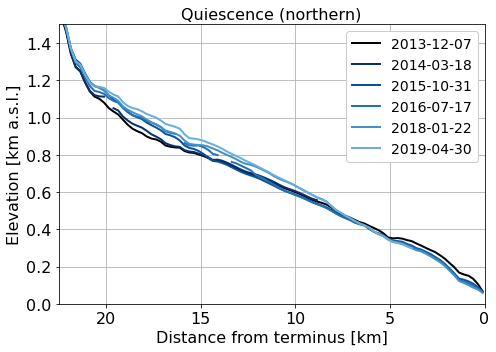

In [157]:
# intialize plot
lw = 2
a = 1
# colors = plt.cm.viridis_r(np.linspace(0,1,9))
colors = plt.cm.Reds_r(np.linspace(0,1,5))
colors = plt.cm.Blues_r(np.linspace(0,1,9))
# fig, ax = plt.subplots(1,figsize=(6.5,4))
fig, ax = plt.subplots(1,figsize=(7,5))
fs = 16
# ax.set_xlim(30,0)
# ax.set_xlim(22,6)
# ax.set_ylim(0.375,1.2)
ax.set_xlim(22.5,0)
ax.set_ylim(0,1.5)

# ax.set_xlim(30,22)
# ax.set_ylim(1.2, 2.4)
ax.set_xlabel('Distance from terminus [km]', fontsize=fs)
ax.set_ylabel('Elevation [km a.s.l.]', fontsize=fs)

plt.tick_params(labelsize=fs)
plt.grid()
plt.tight_layout()

legend_entries = []
legend_objects = []
c = 0
w = 0
# legend_entries.append('2019-04-30')
legend_entries.append('2013-12-07')
ax.plot(ref_elev.dist_m/1000, ref_elev.mean_elev/1000, 'k-', lw=lw) # reference profile
for elevprofile in filelist:
    elev_df = pd.read_csv(elevprofile)
    ds = elevprofile.split('/')[-1].split('_')[-1][:-4]

    # choose which ones
#     if True:
#     if not ds.startswith('2016') or ds.startswith('2015') or ds.startswith('2017') or ds.startswith('2018'):
    
    # do not include 2022 and merged DEMs
    if (((not ds.startswith('20180117') and not ds.startswith('2012') and not ds.startswith('2013')
    and not ds.startswith('20180128')) and (not ds.startswith('2022') and not ds.startswith('202')
    and not ds.startswith('202204')) and not ds.startswith('20211025') and not ds.startswith('20180507'))
    or ds.startswith('20190430')):
        
        if ds.startswith('2012'):
            ax.plot(elev_df.dist_m/1000, elev_df.mean_elev/1000, '-', color='orange', linewidth=lw, alpha=a)
        else:
            # fill between standard error
            if ds.startswith('201'):
                st_err = 2
            elif ds.startswith('2020'):
                st_err = 3
            else:
                st_err = 3
#             ax.fill_between(elev_df.dist_m/1000, 
#                             elev_df.mean_elev/1000 - st_err/1000,
#                            elev_df.mean_elev/1000 + st_err/1000, color=colors[c], alpha=a-0.4)
            
#             ax.fill_between(elev_df.dist_m/1000, 
#                             ref_elev.mean_elev/1000,
#                            elev_df.mean_elev/1000, color=colors[c], alpha=0.3, label=str())
            # plot the line
            leg_obj = ax.plot(elev_df.dist_m/1000, elev_df.mean_elev/1000, '-', color=colors[c], linewidth=lw)
#             legend_objects.append(leg_obj)
            c+=1
            legend_entries.append(ds[0:4]+'-'+ds[4:6]+'-'+ds[6:8])
#         plt.legend(legend_entries, ncol=1, fontsize=fs, facecolor='white', framealpha=1)
# #         plt.savefig(dem_outpath+'figures/DEMs_cline_north_'+ds+'.png',dpi=200)
#         plt.savefig('/Users/jukesliu/Documents/TURNER/paper1/figures/elev_profiles_north_')

plt.legend(legend_entries,fontsize=fs-2,framealpha=1)
plt.title('Quiescence (northern)',fontsize=fs)
# plt.title('Surge (southern)',fontsize=fs)
plt.tight_layout()
plt.savefig('/Users/jukesliu/Documents/TURNER/paper1/figures/elev_profiles_north_quiescence_legend.png',dpi=300)
plt.show()

# 3) Calculate surface slope

2012-08-26 0.06492442366754242
2016-07-17 0.05491503311658456
2018-01-22 0.05640990054626966
2019-04-30 0.05032091890109889
2020-06-05 0.06769050993541324
2021-07-17 0.04715046400415747
2021-10-25 0.04870066879431146
2022-05-22 0.05001616395178818
0.055016010364645734


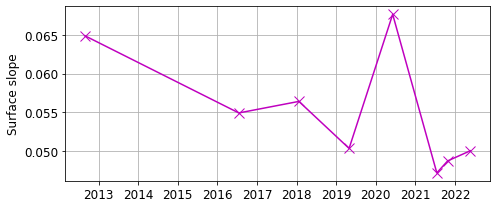

In [128]:
###################
dem_outpath = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/'
outfigpath = '/Users/jukesliu/Documents/TURNER/DATA/figures/'
filelist = os.listdir(dem_outpath); filelist.sort()
# spatial extent for calculation of surface slope [km from terminus]:
EXTENT_START = 0
EXTENT_END = 7
###################

# plot fontsize and colors
fs = 12 # figure fontsize
colors = plt.cm.viridis_r(np.linspace(0,1,len(filelist)))
col_count = 0

date_list = []; slopes = []
for elevprofile in filelist:
    if elevprofile.startswith('centerline_n_250m') and elevprofile.endswith('.csv') and '20' in elevprofile:
        elev_df = pd.read_csv(dem_outpath+elevprofile)
        ds = elevprofile.split('_')[-1][:-4]
        
        if 'me' in ds or 'xx' in ds:
            day = '15' # replace the day with a generic half point in the month
        else:
            day = ds[6:8]
        ds_leg = ds[0:4]+'-'+ds[4:6]+'-'+day
        
        # EVALUATE SURFACE SLOPE AND PLOT
#         if True:
        if ds_leg != '2015-10-31' and ds_leg != '2018-05-07' and ds_leg != '2013-12-07': # only for upper glacier
            if ds_leg != '2018-01-17' and ds_leg != '2018-01-15' and not ds_leg.startswith('2022-04')  and not ds_leg.startswith('2022-02') and ds_leg !='2016-10-19' and ds_leg != '2018-01-28': # incomplete
                surface_slope_df = elev_df[(elev_df.dist_m > EXTENT_START*1000) 
                                           & (elev_df.dist_m < EXTENT_END*1000)] # between 1 and 16 km
                nanmask = ~np.isnan(surface_slope_df.mean_elev)

                if len(surface_slope_df.mean_elev[nanmask]) == 0:
                    continue

                slope, intercept, r, p, std_err = stats.linregress(surface_slope_df.dist_m[nanmask], 
                                                                   surface_slope_df.mean_elev[nanmask])  
                print(ds_leg, slope)
                slopes.append(slope)
                date_list.append(ds_leg)

            col_count+=1
        
plt.figure(figsize=(7,3))
plt.plot(pd.to_datetime(date_list), slopes, 'mx-', markersize=10)
plt.ylabel('Surface slope', fontsize=fs)
# plt.ylim(0.044, 0 .075)
# plt.title(str(EXTENT_START)+' - '+str(EXTENT_END)+' km from the terminus with 250m spacing of mean elevations')
plt.grid()
plt.tick_params(labelsize=fs)
plt.tight_layout()

ss_df = pd.DataFrame(list(zip(date_list, slopes)), columns=['datetime','slope'])
ss_df.to_csv(outfigpath+'surface_slopes_'+str(EXTENT_START)+'to'+str(EXTENT_END)+'km.csv')

print(np.nanmean(slopes))

plt.show()

In [142]:
ds1s = ['20120826','20131207','20140318','20151031','20160717','20180122','20190430','20200605','20210717']
ds2s = ['20131207','20140318','20151031','20160717','20180122','20190430','20200605','20210717','20220522']
slope_changes = [0.041809 - 0.045472, # 2013-2012
                 0.042164 - 0.041809, # 2014-2013
                 0.049204 - 0.042164, # 2015-2014
                 0.050158 - 0.049204, # 2016-2015
                 0.048454 - 0.050158, # 2018-2016
                 0.051320 - 0.048454, # 2019-2018
                 0.045190 - 0.051320, # 2020-2019
                 0.038512 - 0.045190, # 2021-2020
                 0.043279 - 0.038512, # 2022-2021
                ]

ss_td_df = pd.DataFrame(list(zip(ds1s, ds2s, slope_changes)),columns=['ds1','ds2','slope_change'])
ss_td_df

,ds1,ds2,slope_change
0,20120826,20131207,-0.003663
1,20131207,20140318,0.000355
2,20140318,20151031,0.007040
3,20151031,20160717,0.000954
4,20160717,20180122,-0.001704
5,20180122,20190430,0.002866
6,20190430,20200605,-0.006130
7,20200605,20210717,-0.006678
8,20210717,20220522,0.004767


# 4) Calculate elevation differences

In [69]:
# os.listdir(dem_outpath+'for_differencing/')

centerline_n_500m_20131207.csv
centerline_n_500m_20140318.csv
centerline_n_500m_20151031.csv
centerline_n_500m_20160717.csv
centerline_n_500m_20180122.csv
centerline_n_500m_20190430.csv
centerline_n_500m_20200605.csv
centerline_n_500m_20210717.csv
REFERENCE FILE DATE: 20131207


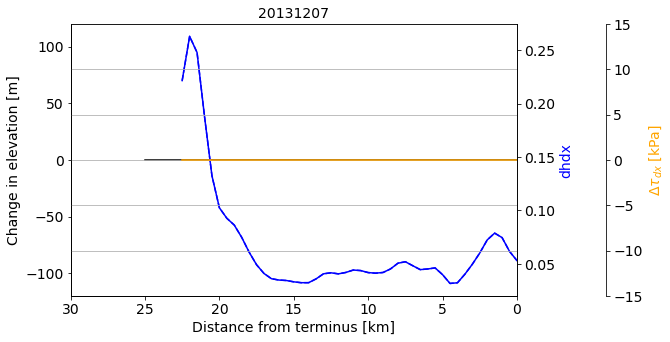

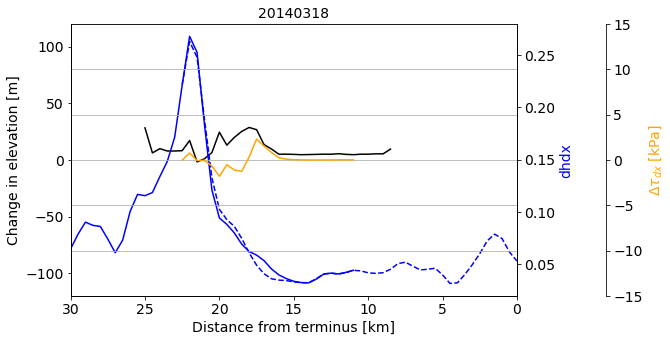

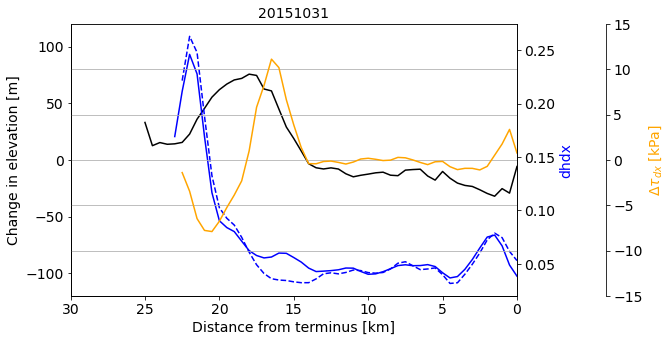

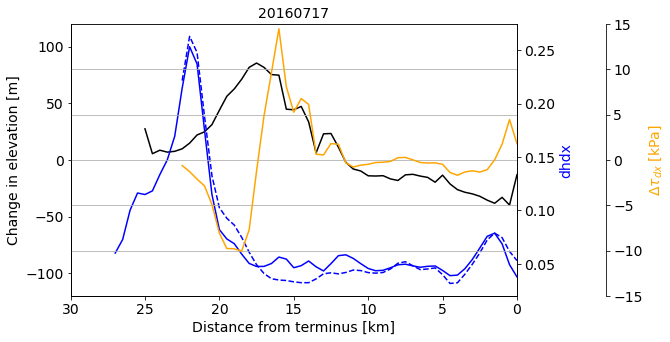

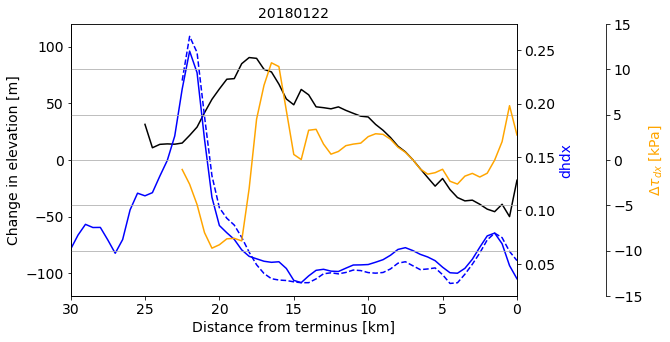

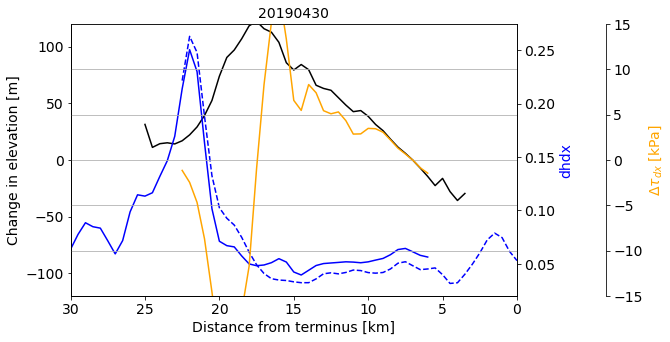

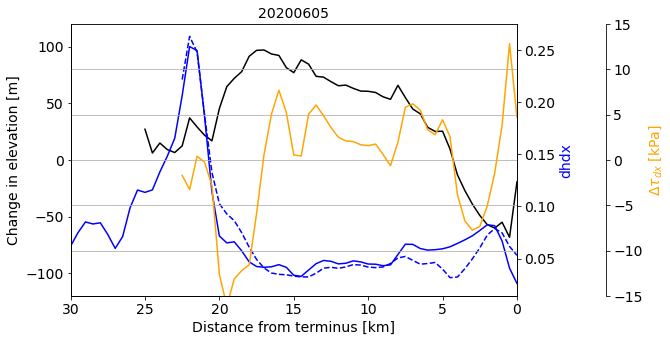

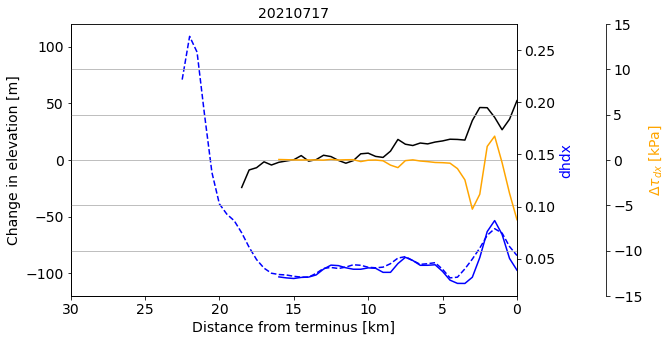

In [132]:
# grab reference elev profile, grab each date after reference OR use ss_td_df to grab elevprofile1 and elevprofile2 along centerline
filelist = glob.glob(dem_outpath+'for_differencing/centerline_n_500*.csv') # change glob search pattern!
filelist.sort() # centerline elevation files
for file in filelist:
    print(file.split('/')[-1])
# filelist = filelist[1:] # grab subset of all files
# print(filelist)

# set gradient spacing:
grad_spacing = 500 # m
SCL= 1500 # m
smoothing_size = SCL/grad_spacing*0.34

# grab the reference profile
ref_elev_df = pd.read_csv(filelist[0]) 
ref_dhdx = np.gradient(gaussian_filter(ref_elev_df.mean_elev, smoothing_size), grad_spacing)
ref_dhdx = -ref_dhdx
ref_date = filelist[0].split('/')[-1].split('_')[-1][:-4]
print('REFERENCE FILE DATE:',ref_date)

for file in filelist:
    ds = file.split('/')[-1].split('_')[-1][:-4]
    elev_df = pd.read_csv(file)
    dhdx = np.gradient(gaussian_filter(elev_df.mean_elev,smoothing_size), 
                       grad_spacing) # calculate surface slope from SCL smoothed elevation
    dhdx=-dhdx # convert to positive gradients
    
    # calculate 1D gradient in slope at spacingx2 for each, add slope back into csv and save
    elev_df['dhdx_1500m'] = dhdx
    elev_df.to_csv(file)
    
    # calculate CHANGE in elev, CHANGE in slope from reference, and CHANGE in driving stress
    delta_dhdx = dhdx - ref_dhdx
    delta_h = elev_df.mean_elev - ref_elev_df.mean_elev
    delta_taud_kpa = delta_h*delta_dhdx*9.81*917/1000
    
    # Plot 
    fig, ax = plt.subplots(1, figsize=(8,5))
    fs=14
    ax.plot(elev_df.dist_m/1000, delta_h, 'k-')
#     ax.plot(elev_df.dist_m/1000, elev_df.mean_elev/1000, 'k-')
#     ax.plot(ref_elev_df.dist_m/1000, ref_elev_df.mean_elev/1000, 'k--') # plot refrence elevation
#     ax.plot(elev_df.dist_m/1000, gaussian_filter(elev_df.mean_elev, smoothing_size)/1000, 'k--') # plot smoothed elevation
    twinax = ax.twinx()
    twinax.plot(ref_elev_df.dist_m/1000, ref_dhdx, 'b--') # plot reference slope
    twinax.plot(elev_df.dist_m/1000, dhdx, 'b-')
    ax.set_xlim(30,0); ax.set_xlabel('Distance from terminus [km]',fontsize=fs)
    ax.set_ylim(-120, 120); ax.set_ylabel('Change in elevation [m]',fontsize=fs)
    twinax.set_ylabel('dhdx',color='blue',fontsize=fs)
    ax.tick_params(labelsize=fs); twinax.tick_params(labelsize=fs)
    plt.title(ds,fontsize=fs)
    

    
    # plot driving stress as 3rd y-axis
    twin2 = ax.twinx()
    twin2.spines.right.set_position(("axes", 1.2))
    twin2.plot(elev_df.dist_m/1000, delta_taud_kpa, '-',color='orange')
    twin2.tick_params(labelsize=fs); twin2.set_ylim(-15,15); twin2.grid()
    twin2.set_ylabel(r'$\Delta \tau_{dx}$ [kPa]',fontsize=fs, color='orange')
    
    # export to csv in form of profile_ds1_ds2_cumulative.csv (elevation and driving slope)
    if ref_date != ds: # only write out the files with differences
        dummy_ds1 = list(ss_td_df[ss_td_df.ds2 == ds].ds1)[0] # grab dummy ds1 from ss_td_df
#         print(dummy_ds1)
        diff_df = pd.DataFrame(list(zip(elev_df.dist_m, delta_h, delta_dhdx, delta_taud_kpa)), 
                               columns=['dist_m','delta_h','delta_dhdx', 'delta_taud_kpa'])
        diff_df.to_csv(dem_outpath+'for_differencing/profile_'+dummy_ds1+'_'+ds+'_cumulative2013.csv')
    plt.show()   

In [149]:
dem_diff_path = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/differenced/'

# grab differenced DEM info:
ds1s = []; ds2s = []; fnames = []
for file in os.listdir(dem_diff_path):
    if file.endswith('.tif'):
        split = file.split('_') # split filename
        ds1 = split[0]; ds2 = split[1]
        
        if ds2.endswith('.tif'):
            ds2 = ds2[:-4] # remove extension
        ds2s.append(ds1); ds1s.append(ds2); fnames.append(file)
        
dem_df = pd.DataFrame(list(zip(ds1s, ds2s, fnames)), columns=['ds1','ds2','fname'])
dem_df = dem_df.sort_values(by='ds1'); dem_df.reset_index(drop=True)

,ds1,ds2,fname


20151031_20131207.tif
20140318_20131207.tif
20160717_20131207.tif
20200605_20131207.tif
20220522_20131207.tif


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_53426/4089570575.py:18: RuntimeWarning: Mean of empty slice
  mean_diffs.append(np.nanmean(crop_array))


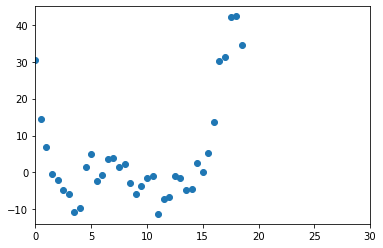

61
201801me_20131207.tif
20170712_20131207.tif
20190430_20131207.tif
20210717_20131207.tif
20200605_20140318.tif
201801me_20140318.tif
20170712_20140318.tif
20190430_20140318.tif
20210717_20140318.tif
20151031_20140318.tif
20160717_20140318.tif


In [233]:
for idx, row in dem_df.iterrows():
    print(row.fname)
    ds1 = row.ds1; ds2 = row.ds2
    
    if not os.path.exists(dem_diff_path+newfolder+'/profile_'+row.ds1+'_'+row.ds2+'.csv'):
        src = rio.open(dem_diff_path+row.fname); elev_diff = src.read(1); affine=src.transform # open it
        
        dists = []; mean_diffs = []
        for idx2, row2 in cline_gdf.iterrows():
            geom = row2.geometry
            dist = row2.distance
            dists.append(dist)
            try:
                out_image, out_transform = mask(src, [mapping(geom)], crop=True)
                crop_array = out_image[0,:,:]
                crop_array[crop_array < -1e30] = np.NaN
#                 print(dist, np.nanmean(crop_array))
                mean_diffs.append(np.nanmean(crop_array))
            except Exception:
                mean_diffs.append(np.NaN)
#                 print(dist, 'no overlap')
                pass
        mean_diffs = np.array(mean_diffs); dists = np.array(dists)
    
#         # calculate change in driving stress from elevation differences
#         slope_change = float(ss_td_df[(ss_td_df.ds1 == ds1) & (ss_td_df.ds2 == ds2)].slope_change)
#         rho = 917 # kg/m3
#         g = 9.81 #m/s2
#         driving_stress = rho*g*mean_diffs*slope_change
        
        if northline: # flip distances for northern centerline
            dists = np.flip(dists)
        mean_diffs[mean_diffs == 0] = np.NaN # differences should never be exactly 0
        plt.plot(dists/1000, mean_diffs, 'o')
        plt.xlim(0, 30)
        plt.show()
        
#         # write centerline data to csv
#         new_df = pd.DataFrame(list(zip(dists, mean_diffs, driving_stress)), 
#                               columns=['dist_m','mean_elev_diff', 'change_td_Pa'])
        
        # write centerline data to csv
        new_df = pd.DataFrame(list(zip(dists, mean_diffs)), 
                              columns=['dist_m','mean_elev_diff'])
        print(len(new_df))
        new_df.to_csv(dem_diff_path+newfolder+'/profile_'+row.ds1+'_'+row.ds2+'.csv')   

# Generate plots

## Plot all elevation difference profiles colored by year

In [143]:
# grab the profiles in order
filenames = []
nofiles = 0 # number of files
# for file in os.listdir(dem_diff_path+newfolder): # Sequential elevation differences
for file in os.listdir(dem_diff_path+newfolder): # Sequential elevation differences
    if file.startswith('profile') and file.endswith('csv'):
        filenames.append(file)
        nofiles+=1
filenames.sort()
filenames

['profile_20131207_20140318_cumulative.csv',
 'profile_20140318_20151031_cumulative.csv',
 'profile_20151031_20160717_cumulative.csv',
 'profile_20160717_20180122_cumulative.csv',
 'profile_20180122_20190430_cumulative.csv',
 'profile_20190430_20200605_cumulative.csv',
 'profile_20200605_20210717_cumulative.csv',
 'profile_20210717_20220522_cumulative.csv']

In [124]:
# filenames = filenames[1:-2]

In [179]:
# fig, ax = plt.subplots(figsize=(10,6))
# fs = 18
# alpha = 0.7
# # background_col='xkcd:pale grey'
# background_col='xkcd:light grey'
# # ax.set_facecolor(background_col)
# colors_cold = cmocean.cm.ice(np.linspace(0,1,6))
# colors_warm = cmocean.cm.matter(np.linspace(0,1,6))

# legends = []
# a = 0
# b = 0
# for filename in filenames:
# #     if filename.startswith('profile_2013'): # only use this conditional for total quiescent
#         [pre, ds1, ds2] = filename.split('_') # grab dates
#         print(ds1, ds2)
#         ds2 = ds2[:-4] # cut off the .csv
#         timeperiod = ds1+' to '+ds2
#     #     legends.append(timeperiod)
#         if ds2.startswith('2018'):
#             ds2 = ('2018 late Jan.')
#         legends.append(ds2)
#         slope_change = float(ss_td_df[ss_td_df.ds1 == ds1].slope_change)
#         df = pd.read_csv(dem_diff_path+newfolder+'/'+filename)

#         if ds2.startswith('202'): # surge
# #             ax.plot(df.dist_m/1000, df.mean_elev_diff, 'o-', color=colors_warm[a], alpha=alpha) # Elevation
#             ax.plot(df.dist_m/1000, df.mean_elev_diff*9.81*917*slope_change/1e3, 'o-', color=colors_warm[a], alpha=alpha) # Driving Stress
#             a += 1
#         elif ds1.startswith('2012'): # end of the last surge
# #             ax.plot(df.dist_m/1000, df.mean_elev_diff, 'o-', color='white') # Elevation
#             ax.plot(df.dist_m/1000, df.mean_elev_diff*9.81*917*slope_change/1000, 'o-', color='white') # Driving stress
#         else:
# #             ax.plot(df.dist_m/1000, df.mean_elev_diff, 'o-', color=colors_cold[b], alpha=alpha) # Elevation
#             ax.plot(df.dist_m/1000, df.mean_elev_diff*9.81*917*slope_change/1000, 'o-', color=colors_cold[b], alpha=alpha) # Driving stress
#             b += 1
    
# ax.set_xlim(27,0)
# ax.set_xlabel('Distance from terminus [km]', fontsize=fs)
# ax.plot([30, 0], [0, 0], 'k-', linewidth=0.5)
# ax.tick_params(axis='both', which='major', labelsize=fs)
# ax.set_ylim(-10,10)
# # ax.set_ylim(-70, 140)
# # ax.set_title('Driving stress difference from 2013-12-07', fontsize=fs)
# ax.set_ylabel('Driving stress change [kPa]', fontsize=fs)
# # ax.set_ylabel('Elevation change [m]', fontsize=fs)
# ax.legend(legends, loc='lower left', ncol=3, fontsize=fs-6)
# ax.grid()
# ax.set_facecolor(background_col)
# plt.show()       

## Plot cumulative elevation change

In [138]:
dem_diff_path = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/differenced/centerline-north'

In [139]:
# grab the profiles in order
filenames = []
nofiles = 0 # number of files
# for file in os.listdir(dem_diff_path+newfolder): # Sequential elevation differences
for file in os.listdir(dem_outpath+'differenced/'): # Sequential elevation differences
    if file.startswith('profile') and not file.endswith('cumulative.csv'):
        filenames.append(file)
        nofiles+=1
filenames.sort()
filenames

['profile_20120826_20131207.csv',
 'profile_20131207_20140318.csv',
 'profile_20140318_20151031.csv',
 'profile_20151031_20160717.csv',
 'profile_20160717_20180122.csv',
 'profile_20180122_20190430.csv',
 'profile_20190430_20200605.csv',
 'profile_20200605_20210717.csv',
 'profile_20210717_20220522.csv']

In [140]:
# quisecence only:
# filenames = filenames[:-1]
filenames = filenames[1:] 
filenames

['profile_20131207_20140318.csv',
 'profile_20140318_20151031.csv',
 'profile_20151031_20160717.csv',
 'profile_20160717_20180122.csv',
 'profile_20180122_20190430.csv',
 'profile_20190430_20200605.csv',
 'profile_20200605_20210717.csv',
 'profile_20210717_20220522.csv']

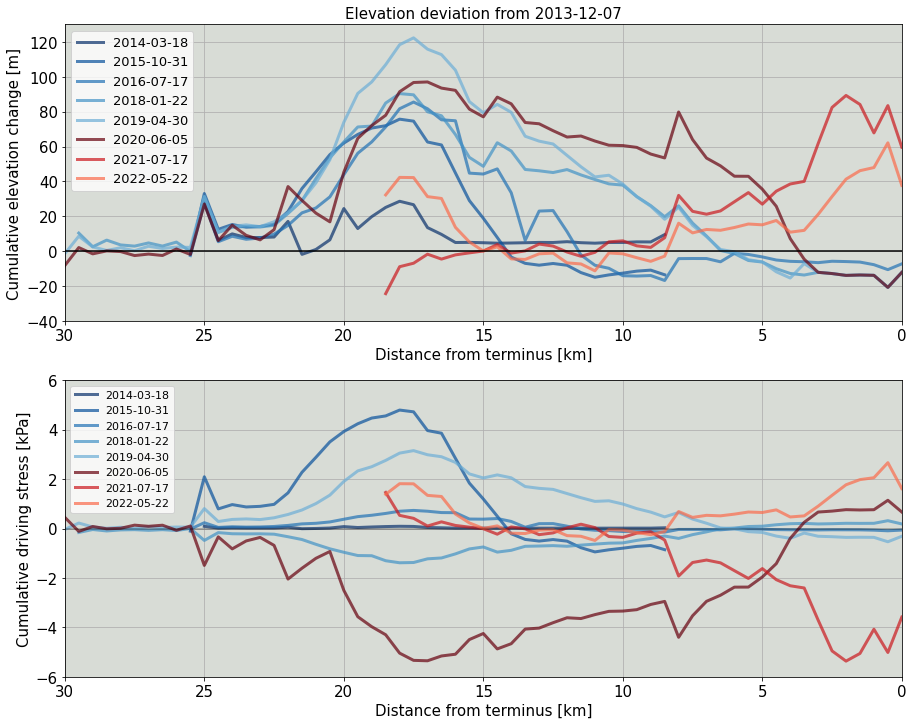

In [148]:
fig, (ax, ax2) = plt.subplots(2,1,figsize=(15,12))
fs = 15
alpha = 0.7
lw = 3
# background_col='xkcd:pale grey'
background_col='xkcd:light grey'
# colors_cold = cmocean.cm.ice(np.linspace(0,1,6))
# colors_warm = cmocean.cm.matter(np.linspace(0,1,6))
colors_warm = plt.cm.Reds_r(np.linspace(0,1,5))
colors_cold = plt.cm.Blues_r(np.linspace(0,1,9))
ax.set_xlim(30,0)

ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_ylim([-40,130])
ax.set_ylabel('Cumulative elevation change [m]', fontsize=fs)
ax.set_xlabel('Distance from terminus [km]', fontsize=fs)

ax2.set_xlim(30,0)
ax2.set_ylim(-6,6)
ax2.tick_params(axis='both', which='major', labelsize=fs)
ax2.set_xlabel('Distance from terminus [km]', fontsize=fs)
ax2.set_ylabel('Cumulative driving stress [kPa]', fontsize=fs)

ax.grid(); ax2.grid()
ax.set_facecolor(background_col); ax2.set_facecolor(background_col)
# ax.set_title('Elevation accumulated since Dec. 2013',fontsize=fs+2)
# ax2.set_title('Driving stress accumulated since Dec. 2013',fontsize=fs+2)

legends = []
a = 0
b = 0
c = 0
ds1s = []; ds2s = []; max_increase_driving_stress = []
for filename in filenames:
    [pre, ds1, ds2] = filename.split('_') # grab dates
    ds2 = ds2[:-4] # cut off the .csv
    timeperiod = ds2
    legends.append(timeperiod[0:4]+'-'+timeperiod[4:6]+'-'+timeperiod[6:8])
    
    # grab the slope change
    slope_change = float(ss_td_df[ss_td_df.ds1 == ds1].slope_change)
      
#     df = pd.read_csv(dem_diff_path+newfolder+'/'+filename)
    df = pd.read_csv(dem_outpath+'differenced/'+filename)
    if c == 0:
        elev_diff = np.array(df.mean_elev_diff)
        elev_diff[np.isnan(elev_diff)] = 0
        cumulative_elev_diff = elev_diff
#     elif ds1 == '20180128':
#         print(elev_diff)
    else:
        elev_diff = np.array(df.mean_elev_diff)
        if not (ds2.startswith('2021') or ds2.startswith('2022')):
            elev_diff[np.isnan(elev_diff)] = 0
        cumulative_elev_diff = cumulative_elev_diff + elev_diff
    max_driving_stress = np.nanmax(elev_diff*9.81*917); 
    max_increase_driving_stress.append(max_driving_stress); ds1s.append(ds1); ds2s.append(ds2)
    nan_cumulative_elev = cumulative_elev_diff.copy() # copy the cumulative_elev_diff
    nan_cumulative_elev[cumulative_elev_diff == 0] = np.NaN
#     ax.plot(df.dist_m/1000, cumulative_elev_diff, 'o-', color=colors[a])

    if ds2.startswith('202'): # surge
        ax.plot(df.dist_m/1000, nan_cumulative_elev, '-', color=colors_warm[a], linewidth=lw, alpha=alpha) # 
        ax2.plot(df.dist_m/1000, nan_cumulative_elev*9.81*917*slope_change/1000, '-', linewidth=lw, color=colors_warm[a],alpha=alpha)
        a += 1
    elif ds1.startswith('2012'): # end of the last surge
        ax.plot(df.dist_m/1000, nan_cumulative_elev, '-', color='white') # # Elevation
    else:
        ax.plot(df.dist_m/1000, nan_cumulative_elev, '-', color=colors_cold[b], linewidth=lw, alpha=alpha) 
        ax2.plot(df.dist_m/1000, nan_cumulative_elev*9.81*917*slope_change/1000, '-', linewidth=lw, color=colors_cold[b],alpha=alpha)
        b += 1
    c += 1
    ax.legend(legends, loc='upper left', ncol=1, fontsize=fs-2) 
    ax2.legend(legends, loc='upper left', ncol=1, fontsize=fs-4)

    
    new_df = pd.DataFrame(list(zip(df.dist_m, nan_cumulative_elev)), columns=['dist_m','cumulative_elev_diff'])
#     new_df.to_csv(dem_outpath+'differenced/'+filename[:-4]+'_cumulative.csv')
    
#     plt.savefig(dem_outpath+'figures/cumulative_dh_dstress_'+ds2+'.png', dpi=200)
ax.plot([30,0],[0,0], 'k-')
ax2.plot([30,0],[0,0], 'k-',alpha=0.3)
ax.set_title('Elevation deviation from 2013-12-07', fontsize=fs)
# fig.savefig(dem_outpath+'figures/cumulative_driving_stress_quiescence_wslope.png', dpi=200)
plt.show()       

NameError: name 'dem_diff_path' is not defined

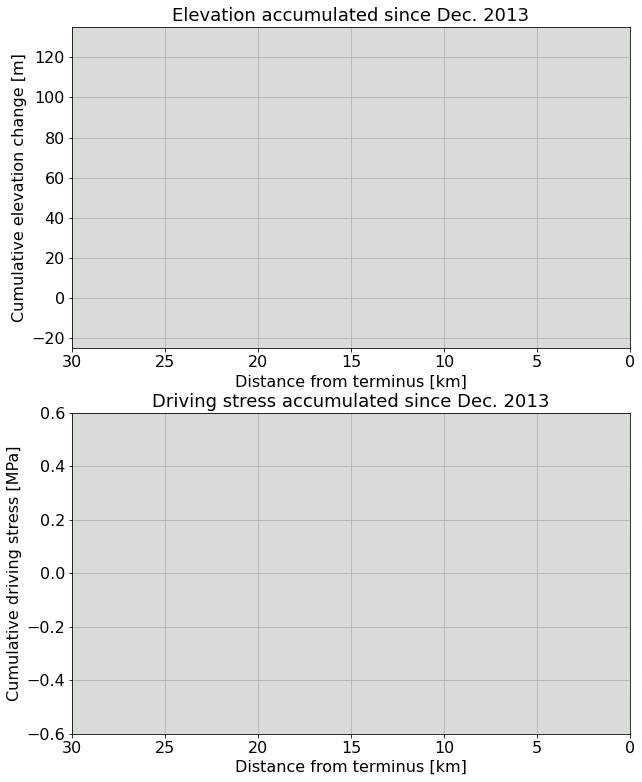

In [139]:
fig, (ax, ax2) = plt.subplots(2,1,figsize=(10,13))
fs = 16
alpha = 0.7
lw = 3
# background_col='xkcd:pale grey'
background_col='xkcd:light grey'
colors_cold = cmocean.cm.ice(np.linspace(0,1,6))
colors_warm = cmocean.cm.matter(np.linspace(0,1,6))
ax.set_xlim(30,0)

ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_ylim([-25,135])
ax.set_ylabel('Cumulative elevation change [m]', fontsize=fs)
ax.set_xlabel('Distance from terminus [km]', fontsize=fs)

ax2.set_xlim(30,0)
ax2.set_ylim(-0.6,0.6)
ax2.tick_params(axis='both', which='major', labelsize=fs)
ax2.set_xlabel('Distance from terminus [km]', fontsize=fs)
ax2.set_ylabel('Cumulative driving stress [MPa]', fontsize=fs)

ax.grid(); ax2.grid()
ax.set_facecolor(background_col); ax2.set_facecolor(background_col)
ax.set_title('Elevation accumulated since Dec. 2013',fontsize=fs+2)
ax2.set_title('Driving stress accumulated since Dec. 2013',fontsize=fs+2)

legends = []
a = 0
b = 0
c = 0
ds1s = []; ds2s = []; max_increase_driving_stress = []
for filename in filenames:
    [pre, ds1, ds2] = filename.split('_') # grab dates
    ds2 = ds2[:-4] # cut off the .csv
    timeperiod = ds2
    legends.append(timeperiod[0:4]+'-'+timeperiod[4:6]+'-'+timeperiod[6:8])
    
    # grab the slope change
    slope_change = float(ss_td_df[ss_td_df.ds1 == ds1].slope_change)
      
    df = pd.read_csv(dem_diff_path+newfolder+'/'+filename)
    if c == 0:
        elev_diff = np.array(df.mean_elev_diff)
        elev_diff[np.isnan(elev_diff)] = 0
        cumulative_elev_diff = elev_diff
#     elif ds1 == '20180128':
#         print(elev_diff)
    else:
        elev_diff = np.array(df.mean_elev_diff)
        if not (ds2.startswith('2021') or ds2.startswith('2022')):
            elev_diff[np.isnan(elev_diff)] = 0
        cumulative_elev_diff = cumulative_elev_diff + elev_diff
    max_driving_stress = np.nanmax(elev_diff*9.81*917); 
    max_increase_driving_stress.append(max_driving_stress); ds1s.append(ds1); ds2s.append(ds2)
    nan_cumulative_elev = cumulative_elev_diff.copy() # copy the cumulative_elev_diff
    nan_cumulative_elev[cumulative_elev_diff == 0] = np.NaN
#     ax.plot(df.dist_m/1000, cumulative_elev_diff, 'o-', color=colors[a])

    if ds2.startswith('202'): # surge
        ax.plot(df.dist_m/1000, nan_cumulative_elev, '-', color=colors_warm[a], linewidth=lw, alpha=alpha) # 
        ax2.plot(df.dist_m/1000, nan_cumulative_elev*9.81*917*slope_change/10000, '-', linewidth=lw, color=colors_warm[a],alpha=alpha)
        a += 1
    elif ds1.startswith('2012'): # end of the last surge
        ax.plot(df.dist_m/1000, nan_cumulative_elev, '-', color='white') # # Elevation
    else:
        ax.plot(df.dist_m/1000, nan_cumulative_elev, '-', color=colors_cold[b], linewidth=lw, alpha=alpha) 
        ax2.plot(df.dist_m/1000, nan_cumulative_elev*9.81*917*slope_change/10000, '-', linewidth=lw, color=colors_cold[b],alpha=alpha)
        b += 1
    c += 1
    ax.legend(legends, loc='upper left', ncol=1, fontsize=fs-4) 
    ax2.legend(legends, loc='upper left', ncol=1, fontsize=fs-4)
    
    plt.savefig(dem_outpath+'figures/cumulative_dh_dstress_'+ds2+'.png', dpi=200)

# fig.savefig(dem_outpath+'figures/cumulative_driving_stress_quiescence_wslope.png', dpi=200)
plt.show()       

In [196]:
# # driving stress
# max_ds_df = pd.DataFrame(list(zip(ds1s, ds2s, max_increase_driving_stress)), columns=['ds1','ds2','max_increase_ds_kPa'])
# max_ds_df


In [195]:
# fig, ax = plt.subplots(figsize=(10,5))
# for idx, row in max_ds_df.iterrows():
#     d1 = datetime.datetime.strptime(row.ds1, '%Y%m%d')
#     d2 = datetime.datetime.strptime(row.ds2, '%Y%m%d')
#     ax.plot([d1, d2], [row.max_increase_ds_kPa, row.max_increase_ds_kPa],'k-',linewidth=3)

# ax.grid()
# ax.tick_params(axis='both',labelsize=fs)
# ax.set_ylabel('Driving stress increase [kPa]', fontsize=fs)
# fig.savefig(dem_outpath+'figures/increase_driving_stress_quiescence_noslope.png', dpi=200)
# plt.show()

## Plot one driving stress profile

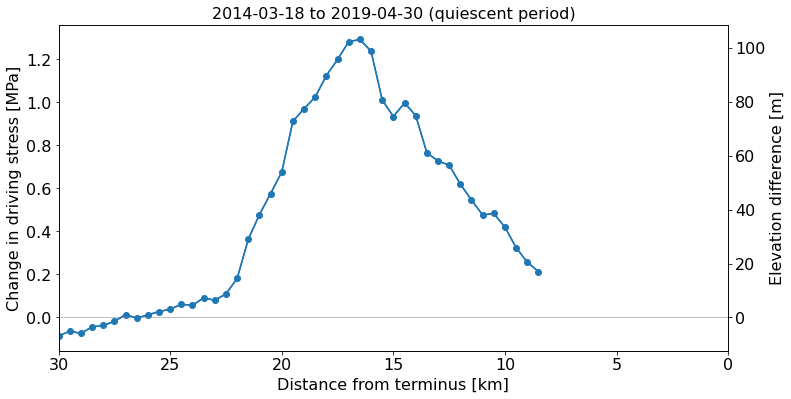

In [436]:
prof_df = pd.read_csv(dem_diff_path+newfolder+'/total_quiescent/profile_20140318_20190430.csv')
fs = 16

fig, ax = plt.subplots(figsize=(12,6))
twin1 = ax.twinx()

ax.plot(prof_df.dist_m/1000, prof_df.change_in_driving_stress_Pa*(0.053484 - 0.039550)/10000, 'o-')
ax.plot([30, 0], [0, 0], '-', color='gray',linewidth=0.5)
# plt.plot([30, 0], [0, 0], '-', color='gray',linewidth=0.5)
ax.set_ylabel('Change in driving stress [MPa]',fontsize=fs)
ax.set_xlabel('Distance from terminus [km]',fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
plt.title('2014-03-18 to 2019-04-30 (quiescent period)', fontsize=fs)
ax.set_xlim(30,0)

twin1.plot(prof_df.dist_m/1000, prof_df.mean_elev_diff,'-')
twin1.set_ylabel('Elevation difference [m]',fontsize=fs)
twin1.tick_params(axis='both', which='major', labelsize=fs)
fig.savefig(dem_outpath+'figures/total_driving_stress_quiescence_wslope.png', dpi=200)
plt.show()

## Plot bed elevations:

In [226]:
# sIPR
sIPR_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/bed/sIPR/sIPR_proj_data.csv')
sIPR_df.head()

,sIPR_UTMx_proj,sIPR_UTMy_proj,sIPR_dist_km_proj,Pick_depth
0,570661.311252,6.658280e+06,0.357101,-357.03
1,570662.688259,6.658279e+06,1.936953,-356.68
2,570664.025658,6.658278e+06,3.471361,-356.68
3,570666.759973,6.658277e+06,6.608462,-356.68
4,570668.075655,6.658276e+06,8.117954,-356.00


In [227]:
# extract bed elevations along centerline
from shapely.geometry import Polygon, Point, MultiPolygon
dists = []; mean_depths = []
for idx2, row2 in cline_gdf.iterrows(): # NEED 250m centerline
    geom = row2.geometry
    dist = row2.distance
    poly = Polygon(geom) # square polygon
    
    depths = []
    for idx, row in sIPR_df.iterrows():
        depth = row.Pick_depth
        point = Point(row.sIPR_UTMx_proj, row.sIPR_UTMy_proj)
        if poly.contains(point):
            depths.append(depth)
    mean_depth = np.nanmean(depths)
    dists.append(dist); mean_depths.append(mean_depth)
dists.reverse() # reverse the distances
bed_df = pd.DataFrame(list(zip(dists, mean_depths)), columns=['dist_m','mean_sIPR_depth'],dtype=float)
bed_df = bed_df[~np.isnan(bed_df.mean_sIPR_depth)]
bed_df

/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_1221/3192313712.py:15: RuntimeWarning: Mean of empty slice
  mean_depth = np.nanmean(depths)


,dist_m,mean_sIPR_depth
82,9600.0,-350.032653
83,9350.0,-347.036812
84,9100.0,-352.672121
85,8850.0,-323.240333
86,8600.0,-312.423000
87,8350.0,-306.310000


In [228]:
df2020 = pd.read_csv(dem_outpath+'centerline_n_250m_20200605.csv', usecols=[1,2],dtype=float)
df2020

,dist_m,mean_elev
0,30100.0,2398.708500
1,29850.0,2375.599000
2,29600.0,2347.267800
3,29350.0,2323.523000
4,29100.0,2287.253400
...,...,...
116,1100.0,97.178566
117,850.0,84.588480
118,600.0,68.902440
119,350.0,66.976230


In [229]:
df2020.merge(bed_df,on='dist_m')

,dist_m,mean_elev,mean_sIPR_depth
0,9600.0,639.02893,-350.032653
1,9350.0,625.77924,-347.036812
2,9100.0,611.35425,-352.672121
3,8850.0,601.32150,-323.240333
4,8600.0,598.22620,-312.423000
5,8350.0,598.39380,-306.310000


In [230]:
new_df = df2020.merge(bed_df, on='dist_m')
new_df['bed_elev'] = new_df.mean_elev + new_df.mean_sIPR_depth
# calculate driving stress from thickness and slope 
slope_a = 0.0407 # 06/2020, 0-20 km
new_df['tau_d'] = np.abs(new_df.mean_sIPR_depth)*9.81*917*slope_a
new_df
# new_df.dropna()
# new_df.to_csv('/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/sIPR_tau_d.csv')

,dist_m,mean_elev,mean_sIPR_depth,bed_elev,tau_d
0,9600.0,639.02893,-350.032653,288.996277,128156.698845
1,9350.0,625.77924,-347.036812,278.742428,127059.837882
2,9100.0,611.35425,-352.672121,258.682129,129123.081615
3,8850.0,601.32150,-323.240333,278.081167,118347.284721
4,8600.0,598.22620,-312.423000,285.803200,114386.757844
5,8350.0,598.39380,-306.310000,292.083800,112148.618364


In [237]:
Millan_herr_df[(Millan_h_df.dist_m > 8300) & (Millan_h_df.dist_m < 9700)]

,dist_m,h_err
82,9600.0,56.0
83,9350.0,56.0
84,9100.0,56.0
85,8850.0,56.0
86,8600.0,56.0
87,8350.0,57.0


In [239]:
print((Millan_h_df[(Millan_h_df.dist_m > 8300) & (Millan_h_df.dist_m < 9700)].h-56)*9.81*917*slope_a)

82    46093.034551
83    40024.879344
84    39044.722168
85    42989.540940
86    50555.653281
87    54254.053373
Name: h, dtype: float64


In [232]:
# Millan
Millan_surf_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/centerline_n_250m_20180122.csv',
                            names=['idx','dist_m','surface_elev'],usecols=[1,2],skiprows=1)
Millan_h_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/centerline_n_250m_h.csv',
                         names=['idx','dist_m','h'],usecols=[1,2],skiprows=1)
Millan_herr_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/centerline_n_250m_herr.csv',
                            names=['idx','dist_m','h_err'],usecols=[1,2],skiprows=1)
# Millan_surf_df
Millan_h_df


,dist_m,h
0,30100.0,222.366490
1,29850.0,221.125150
2,29600.0,214.023300
3,29350.0,212.245940
4,29100.0,226.235300
...,...,...
116,1100.0,83.256370
117,850.0,94.044890
118,600.0,109.037130
119,350.0,104.761890


In [233]:
Millan_merged_df = Millan_surf_df.merge(Millan_h_df,on='dist_m').merge(Millan_herr_df,on='dist_m')
Millan_merged_df

,dist_m,surface_elev,h,h_err
0,30100.0,2406.212891,222.366490,57.0
1,29850.0,2381.678711,221.125150,57.0
2,29600.0,2355.566895,214.023300,57.0
3,29350.0,2329.444092,212.245940,57.0
4,29100.0,2290.409668,226.235300,57.0
...,...,...,...,...
116,1100.0,112.488480,83.256370,40.0
117,850.0,100.550964,94.044890,40.0
118,600.0,87.110077,109.037130,47.0
119,350.0,76.554176,104.761890,47.0


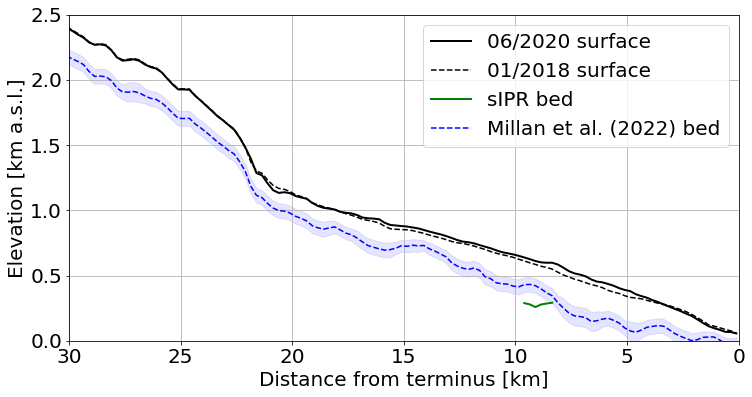

In [240]:
fs = 20
fig, ax = plt.subplots(figsize=(12,6))
# twin1 = ax.twinx()

# sIPR transect begins at 9.5 km from terminus
ax.plot(df2020.dist_m/1000, df2020.mean_elev/1000, 'k-', linewidth=2) # surface 2020
ax.plot(Millan_merged_df.dist_m/1000, Millan_surf_df.surface_elev/1000, 'k--') # surface 2018

ax.plot(new_df.dist_m/1000, new_df.bed_elev/1000, 'g-', linewidth=2)
# ax.plot(9.5-sIPR_df.sIPR_dist_km_proj/1000, sIPR_df.Pick_depth, 'g.-') # sIPR
# ax.plot([30, 0],[0,0],'g-',alpha=0.5)

ax.plot(Millan_merged_df.dist_m/1000, (Millan_merged_df.surface_elev - Millan_merged_df.h)/1000, 'b--') # bed elev
# error bars on bed elev:
ax.fill_between(Millan_merged_df.dist_m/1000, 
                (Millan_merged_df.surface_elev - Millan_merged_df.h - Millan_merged_df.h_err)/1000,
        (Millan_merged_df.surface_elev - Millan_merged_df.h + Millan_merged_df.h_err)/1000,color='blue',alpha=0.1)
# ax.plot(Millan_merged_df.dist_m/1000,
#            (Millan_merged_df.surface_elev - Millan_merged_df.h - Millan_merged_df.h_err)/1000,'--',color='gray')
# ax.plot(Millan_merged_df.dist_m/1000, 
#            (Millan_merged_df.surface_elev - Millan_merged_df.h + Millan_merged_df.h_err)/1000,'--',color='gray',)



# # Millan:
# twin1.plot(Millan_merged_df.dist_m/1000, Millan_surf_df.surface_elev, 'b--') # surface
# twin1.plot(Millan_merged_df.dist_m/1000, Millan_merged_df.surface_elev - Millan_merged_df.h, 'k--') # bed elev
# # error bars on bed elev:
# twin1.plot(Millan_merged_df.dist_m/1000, 
#            Millan_merged_df.surface_elev - Millan_merged_df.h - Millan_merged_df.h_err,'--',color='gray')
# twin1.plot(Millan_merged_df.dist_m/1000, 
#            Millan_merged_df.surface_elev - Millan_merged_df.h + Millan_merged_df.h_err,'--',color='gray',)

# plot params
ax.set_ylabel('Elevation [km a.s.l.]',fontsize=fs)
# twin1.set_ylabel('Elevation [m a.s.l.]',fontsize=fs)
# twin1.legend(['01/2018 surface','Millan et al. (2022) bed'],loc='lower left',fontsize=fs)
# twin1.tick_params(axis='both', which='major', labelsize=fs)

ax.legend(['06/2020 surface', '01/2018 surface','sIPR bed','Millan et al. (2022) bed'],
          loc = 'upper right',fontsize=fs)
ax.set_xlabel('Distance from terminus [km]',fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_xlim(30,0)
ax.set_ylim(0,2.5)
# for axis in [ax, twin1]:
#     axis.set_ylim(0,1200)
ax.grid()

# twin1.plot(prof_df.dist_m/1000, prof_df.mean_elev_diff,'-')
# twin1.set_ylabel('Elevation difference [m]',fontsize=fs)
# twin1.tick_params(axis='both', which='major', labelsize=fs)
plt.show()